In [57]:
import glob
import gzip
import os
import pathlib
import zipfile
from collections import defaultdict
from typing import Dict, List, Literal, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
import logging

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pv
import pynumdiff
import scipy
import seaborn as sns
from scipy.signal import savgol_filter
from tqdm import tqdm

import fly_analysis as fa


## Helper functions

### Braidz

In [58]:
def read_csv_pyarrow(file_obj) -> Optional[pd.DataFrame]:
    """
    Read a CSV file using pyarrow and convert it to a pandas DataFrame.

    Args:
        file_obj (file-like object): The file-like object containing the CSV data.

    Returns:
        Optional[pd.DataFrame]: The pandas DataFrame containing the CSV data, or None if the file is invalid.

    Raises:
        pa.ArrowInvalid: If the file is invalid and cannot be read by pyarrow.

    """
    try:
        table = pv.read_csv(
            file_obj, read_options=pv.ReadOptions(skip_rows_after_names=1)
        )
        return table.to_pandas()
    except pa.ArrowInvalid:
        return None


def read_csv_pandas(file_obj) -> Optional[pd.DataFrame]:
    """
    Reads a CSV file using pandas and returns a DataFrame.

    Args:
        file_obj (str or file-like object): The file path or file-like object to read.

    Returns:
        Optional[pd.DataFrame]: A DataFrame containing the data from the CSV file, or None if the file is empty.

    Raises:
        pd.errors.EmptyDataError: If the file is empty.
    """
    try:
        return pd.read_csv(file_obj, comment="#")
    except pd.errors.EmptyDataError:
        return None


def _read_from_file(
    filename: str, parser: Literal["pandas", "pyarrow"] = "pyarrow"
) -> Tuple[Optional[pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Reads data from a .braidz file using either PyArrow or pandas for CSV parsing.

    This function opens a .braidz file, reads the 'kalman_estimates.csv.gz' file into a pandas DataFrame,
    and also reads any other .csv files present in the .braidz file into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the .braidz file.
    parser (str): The parser to use for reading CSV files. Either "pandas" or "pyarrow". Default is "pyarrow".

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if parser not in ["pandas", "pyarrow"]:
        raise ValueError("parser must be either 'pandas' or 'pyarrow'")

    filepath = pathlib.Path(filename)
    csv_s: Dict[str, pd.DataFrame] = {}

    read_csv = read_csv_pyarrow if parser == "pyarrow" else read_csv_pandas

    with zipfile.ZipFile(file=filepath, mode="r") as archive:
        print(f"Reading {filename} using {parser}")

        # Read kalman_estimates.csv.gz
        try:
            with archive.open("kalman_estimates.csv.gz") as file:
                if parser == "pandas":
                    df = read_csv(gzip.open(file, "rt"))
                else:  # pyarrow
                    with gzip.open(file, "rb") as unzipped:
                        df = read_csv(unzipped)
            if df is None or df.empty:
                return None, None
        except KeyError:
            print(f"kalman_estimates.csv.gz not found in {filename}")
            return None, None

        # Read other CSV files
        csv_files = [csv for csv in archive.namelist() if csv.endswith(".csv")]
        for csv_file in csv_files:
            key, _ = os.path.splitext(csv_file)
            try:
                csv_s[key] = pd.read_csv(archive.open(csv_file))
            except pd.errors.EmptyDataError:
                continue

    return df, csv_s


def _read_from_folder(filename: str) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a specified folder into a pandas DataFrame,
    and also reads any other .csv files present in the folder into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the folder.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    df = pd.read_csv(
        os.path.join(filename, "kalman_estimates.csv.gz"),
        comment="#",
        compression="gzip",
    )
    csv_files = glob.glob(f"{filename}/*.csv")

    csv_s = {}
    for csv_file in csv_files:
        key, _ = os.path.splitext(csv_file)
        try:
            csv_s[key] = pd.read_csv(csv_file)
        except pd.errors.EmptyDataError:
            continue

    return df, csv_s


def _extract_to_folder(filename: str, read_extracted: bool = False) -> str:
    """
    Extracts a .braidz file to a folder.

    This function extracts all the files from a .braidz file to a folder with the same name as the .braidz file.
    If the folder already exists, it does nothing. If read_extracted is True, it also reads the extracted files.

    Parameters:
    filename (str): The path to the .braidz file.
    read_extracted (bool): Whether to read the extracted files. Default is False.

    Returns:
    str: The path to the folder where the files were extracted.
    """
    extract_path = os.path.splitext(filename)[0]
    if not os.path.exists(extract_path):
        os.mkdir(extract_path)
    # else:
    # return _read_from_folder(extract_path)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        # Get the total number of files inside the zip
        total_files = len(zip_ref.infolist())

        # Loop through each file, extract it, and update the tqdm progress bar
        with tqdm(total=total_files, unit="file") as pbar:
            for member in zip_ref.infolist():
                # Extract a single file
                zip_ref.extract(member, extract_path)
                pbar.update(1)

    if read_extracted:
        return _read_from_folder(extract_path)

    return extract_path


def validate_file(filename: str):
    """
    Validates that the file is of the expected type.

    Parameters:
    filename (str): The path to the file.

    Raises:
    ValueError: If the file is not of the expected type.
    """
    if not filename.endswith(".braidz"):
        raise ValueError(f"File {filename} is not of the expected '.braidz' type")


def validate_directory(filename: str):
    """
    Validates that the directory contains the expected files.

    Parameters:
    filename (str): The path to the directory.

    Raises:
    ValueError: If the directory does not contain the expected files.
    """
    if not any(fname.endswith(".csv.gz") for fname in os.listdir(filename)):
        raise ValueError(f"Directory {filename} does not contain any '.csv.gz' files")


def read_braidz(
    filename: str, extract_first: bool = False
) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a .braidz file or a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a .braidz file or a folder into a pandas DataFrame,
    and also reads any other .csv files present into a dictionary of pandas DataFrames.
    If extract_first is True, it first extracts the .braidz file to a folder.

    Parameters:
    filename (str): The path to the .braidz file or folder.
    extract_first (bool): Whether to first extract the .braidz file to a folder. Default is False.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if os.path.isfile(filename):
        validate_file(filename)
        if extract_first:
            df, csvs = _extract_to_folder(filename, read_extracted=True)
        else:
            df, csvs = _read_from_file(filename)

    elif os.path.isdir(filename):
        validate_directory(filename)
        df, csvs = _read_from_folder(filename)

    else:
        raise FileNotFoundError(f"Path {filename} does not exist")

    return df, csvs

### Analysis

In [59]:
def read_single_file(file_path: str):
    """
    Read a single braidz file.

    Args:
        file_path (str): The path to the braidz file.

    Returns:
        The content of the braidz file.
    """
    return read_braidz(file_path)


def get_angular_velocity(df, idx_before, idx_after):
    """
    Calculate the angular velocity from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'xvel' and 'yvel' columns.
        idx_before (int): The starting index for calculation.
        idx_after (int): The ending index for calculation.

    Returns:
        numpy.ndarray: The calculated angular velocity between idx_before and idx_after.
    """
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    thetas = np.arctan2(yvel, xvel)
    thetas_u = np.unwrap(thetas)
    angular_velocity = np.gradient(thetas_u) / (0.01)

    return angular_velocity[idx_before:idx_after]


def get_angular_velocity_optimized(df, idx_before, idx_after, time_step=0.01):
    # Extract velocity components
    xvel = df["xvel"].values
    yvel = df["yvel"].values

    # Calculate velocity magnitudes
    vel_magnitudes = np.sqrt(xvel**2 + yvel**2)

    # Normalize velocities
    xvel_norm = xvel / vel_magnitudes
    yvel_norm = yvel / vel_magnitudes

    # Calculate dot products
    dot_products = xvel_norm[:-1] * xvel_norm[1:] + yvel_norm[:-1] * yvel_norm[1:]

    # Clip dot products to avoid numerical issues
    dot_products = np.clip(dot_products, -1, 1)

    # Calculate angular velocities
    angular_velocities = np.arccos(dot_products) / time_step

    # Add NaN at the beginning to match original function's output length
    angular_velocities = np.insert(angular_velocities, 0, np.nan)

    return angular_velocities[idx_before:idx_after]


def get_linear_velocity(df, idx_before, idx_after):
    """
    Calculate the linear velocity from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'xvel' and 'yvel' columns.
        idx_before (int): The starting index for calculation.
        idx_after (int): The ending index for calculation.

    Returns:
        numpy.ndarray: The calculated linear velocity between idx_before and idx_after.
    """
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    linvel = np.sqrt(xvel**2 + yvel**2)
    return linvel[idx_before:idx_after]


def get_trajectory(df, idx_before, idx_after):
    """
    Extract the trajectory from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'x', 'y', and 'z' columns.
        idx_before (int): The starting index for extraction.
        idx_after (int): The ending index for extraction.

    Returns:
        numpy.ndarray: The extracted trajectory between idx_before and idx_after.
    """
    return df[["x", "y", "z"]].to_numpy()[idx_before:idx_after]


def get_mean_and_std(data: np.array, abs: bool = False):
    """
    Calculate the mean, standard deviation, and standard error of the mean for given data.

    Args:
        data (numpy.array): The input data array.
        abs (bool, optional): If True, use absolute values of the data. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - mean (numpy.ndarray): The mean of the data.
            - std (numpy.ndarray): The standard deviation of the data.
            - sem (numpy.ndarray): The standard error of the mean of the data.
    """
    d = np.abs(data) if abs else data
    mean = np.nanmean(d, axis=0)
    std = np.nanstd(d, axis=0)
    sem = scipy.stats.sem(d, axis=0)

    return mean, std, sem


def plot_with_mean_and_std(
    data: np.array,
    units="frames",
    color=None,
    label=None,
    ax=None,
    xlabel=None,
    ylabel=None,
):
    """
    Plot data with mean and standard deviation.

    Args:
        data (np.array): The input data to plot.
        units (str, optional): The units for the x-axis. Either "frames" or "milliseconds". Defaults to "frames".
        color (str, optional): The color to use for the plot. Defaults to None.
        label (str, optional): The label for the plot legend. Defaults to None.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. If None, use the current axes. Defaults to None.
        xlabel (str, optional): The label for the x-axis. Defaults to None.
        ylabel (str, optional): The label for the y-axis. Defaults to None.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()

    mean, std, sem = get_mean_and_std(data, abs=True)

    if units == "frames":
        X = np.arange(len(mean))
    elif units == "milliseconds":
        X = np.arange(len(mean)) * 0.01

    ax.plot(X, mean, color=color, label=label)
    ax.fill_between(X, mean - std, mean + std, color=color, edgecolor=None, alpha=0.5)

    if label:
        ax.legend()
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)


def rotate_trajectory(trajectory, angle):
    """
    Rotate a 2D trajectory by a given angle.

    Args:
        trajectory (np.array): The input trajectory to rotate.
        angle (float): The angle of rotation in radians.

    Returns:
        np.array: The rotated trajectory.
    """
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    return np.dot(trajectory, rotation_matrix.T)


def translate_trajectory(trajectory, heading_dt=10):
    """
    Translate and rotate a trajectory to align with the positive y-axis and start from (0,0).

    Args:
        trajectory (np.array): The input trajectory to translate and rotate.
        heading_dt (int, optional): The number of points to use for calculating the initial heading. Defaults to 10.

    Returns:
        np.array: The translated and rotated trajectory.
    """
    initial_vector = trajectory[heading_dt] - trajectory[0]
    initial_angle = np.arctan2(initial_vector[1], initial_vector[0])

    rotation_angle = np.pi / 2 - initial_angle
    rotated_trajectory = rotate_trajectory(trajectory, rotation_angle)

    translated_trajectory = rotated_trajectory - rotated_trajectory[0]

    return translated_trajectory


def align_and_rotate_trajectories(
    coordinates: List[np.array],
    start_idx: int = 50,
    end_idx: int = 100,
    heading_dt: int = 10,
) -> List[np.array]:
    """
    Align and rotate multiple trajectories.

    Args:
        coordinates (List[np.array]): A list of input trajectories to align and rotate.
        start_idx (int, optional): The starting index for processing each trajectory. Defaults to 50.
        end_idx (int, optional): The ending index for processing each trajectory. Defaults to 100.
        heading_dt (int, optional): The number of points to use for calculating the initial heading. Defaults to 10.

    Returns:
        List[np.array]: A list of aligned and rotated trajectories.
    """
    rotated_trajectories = []

    for traj in coordinates:
        traj = traj[start_idx:end_idx, :2]
        aligned_trajectory = translate_trajectory(traj, heading_dt=heading_dt)
        rotated_trajectories.append(aligned_trajectory)
    return rotated_trajectories


def get_dispersion(groups: List[List[np.array]]):
    """
    Calculate the dispersion (heading angles) for groups of trajectories.

    Args:
        groups (List[List[np.array]]): A list of groups, where each group is a list of trajectories.

    Returns:
        List[List[float]]: A list of lists containing heading angles for each trajectory in each group.
    """
    dispersion = [[] for _ in range(len(groups))]
    for i, group_trajectories in enumerate(groups):
        for traj in group_trajectories:
            heading_angle = np.arctan2(
                traj[-1, 1] - traj[0, 1], traj[-1, 0] - traj[0, 0]
            )
            dispersion[i].append(heading_angle)
    return dispersion


def angdiff(
    angle1: float, angle2: float, range_start: float = -np.pi, range_end: float = np.pi
) -> float:
    """
    Calculate the shortest angular difference between two angles.

    Args:
        angle1 (float): First angle in radians.
        angle2 (float): Second angle in radians.
        range_start (float, optional): Start of the angle range. Defaults to -pi.
        range_end (float, optional): End of the angle range. Defaults to pi.

    Returns:
        float: Shortest angular difference in radians.
    """

    def normalize_angle(angle):
        range_size = range_end - range_start
        return (angle - range_start) % range_size + range_start

    angle1 = normalize_angle(angle1)
    angle2 = normalize_angle(angle2)

    diff = angle2 - angle1

    range_size = range_end - range_start
    if diff > range_size / 2:
        diff -= range_size
    elif diff < -range_size / 2:
        diff += range_size

    return diff


def calculate_heading_change(
    trajectories: np.array,
    central_point: int = 50,
    dt_before: int = 10,
    dt_after: int = 50,
) -> np.array:
    """
    Calculate the change in heading for each trajectory.

    Args:
        trajectories (np.array): Numpy array of shape [n, 150, 3] containing n trajectories.
        central_point (int, optional): Index of the central point (0-149). Defaults to 50.
        dt_before (int, optional): Number of points to consider before the central point. Defaults to 10.
        dt_after (int, optional): Number of points to consider after the central point. Defaults to 50.

    Returns:
        np.array: Numpy array of shape [n] containing heading changes in radians.
    """
    n = trajectories.shape[0]
    heading_changes = np.zeros(n)

    for i in range(n):
        trajectory = trajectories[i]

        before_point = max(0, central_point - dt_before)
        after_point = min(149, central_point + dt_after)

        before_vector = trajectory[central_point, :2] - trajectory[before_point, :2]
        after_vector = trajectory[after_point, :2] - trajectory[central_point, :2]

        before_angle = np.arctan2(before_vector[1], before_vector[0])
        after_angle = np.arctan2(after_vector[1], after_vector[0])

        heading_change = after_angle - before_angle

        heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi

        heading_changes[i] = heading_change

    return heading_changes


def get_data(df: pd.DataFrame, stim: pd.DataFrame, keys: list | str):
    """
    Extract specified data from DataFrames based on given keys.

    Args:
        df (pd.DataFrame): The main DataFrame containing trajectory data.
        stim (pd.DataFrame): DataFrame containing stimulus information.
        keys (list or str): The keys specifying which data to extract.

    Returns:
        dict: A dictionary containing the extracted data for each key.

    Raises:
        ValueError: If a key is not recognized.
    """
    keys = [keys] if isinstance(keys, str) else keys
    data_dict = {key: [] for key in keys}

    extraction_functions = {
        "angular_velocity": get_angular_velocity_optimized,
        "linear_velocity": get_linear_velocity,
        "xyz": get_trajectory,
    }

    for _, row in stim.iterrows():
        try:
            obj_id = int(row["obj_id"])
            frame = int(row["frame"])
        except ValueError:
            continue

        obj_group = df[df["obj_id"] == obj_id]
        frame_indices = np.where(obj_group["frame"] == frame)[0]
        if len(frame_indices) == 0:
            continue

        frame_idx = frame_indices[0]

        idx_before = frame_idx - 50
        idx_after = frame_idx + 100

        if idx_before < 0 or idx_after >= len(obj_group):
            continue

        obj_group["xvel_old"] = obj_group["xvel"]
        obj_group["yvel_old"] = obj_group["yvel"]

        x = obj_group.x.to_numpy()
        y = obj_group.y.to_numpy()

        _, obj_group["xvel"] = pynumdiff.smooth_finite_difference.butterdiff(
            x, dt=0.01, params=[1, 0.1]
        )
        _, obj_group["yvel"] = pynumdiff.smooth_finite_difference.butterdiff(
            y, dt=0.01, params=[1, 0.1]
        )

        for key in keys:
            if key not in extraction_functions:
                print(f"Key {key} not recognized.")
            data_dict[key].append(
                extraction_functions[key](obj_group, idx_before, idx_after)
            )

    for key in keys:
        if key != "xyz":
            data_dict[key] = np.array(data_dict[key])

    return data_dict


def process_single_file(file_data, keys=["angular_velocity", "linear_velocity", "xyz"]):
    """
    Process data from a single file.

    Args:
        file_data (tuple): A tuple containing the main DataFrame and the stimulus DataFrame.
        keys (list): The keys specifying which data to extract.

    Returns:
        dict: A dictionary containing the extracted data for each key.
    """
    df = file_data[0]
    stim = file_data[1]["stim"] if "stim" in file_data[1] else file_data[1]["opto"]
    return get_data(df, stim, keys)


def process_files(file_list: list, root_folder: str, keys: list):
    """
    Process multiple files and combine their data.

    Args:
        file_list (list): A list of file names to process.
        root_folder (str): The root folder containing the files.
        keys (list): The keys specifying which data to extract.

    Returns:
        tuple: A tuple containing two dictionaries:
            - combined_data (dict): The combined extracted data for each key.
            - file_sources (dict): The source file for each piece of data.
    """
    combined_data = defaultdict(list)
    file_sources = defaultdict(list)

    for file in file_list:
        file_path = os.path.join(root_folder, file)
        print(f"Processing file: {file}")

        try:
            file_data = read_single_file(file_path)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue

        try:
            file_results = process_single_file(file_data, keys)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

        for key in keys:
            combined_data[key].extend(file_results[key])
            file_sources[key].extend([file] * len(file_results[key]))

        del file_data

    for key in keys:
        combined_data[key] = np.array(combined_data[key])

    return dict(combined_data), dict(file_sources)


def calculate_heading_amplitude(
    trajectories,
    stimulus_frame=50,
    stimulus_duration=30,
    response_delay=10,
    baseline_duration=20,
):
    """
    Calculate the heading amplitude change in trajectories before and after a stimulus.

    This function computes the change in heading angle between a baseline period
    before the stimulus and a response period after the stimulus. It returns both
    the signed angle change and the absolute magnitude of the change (amplitude).

    Args:
        trajectories (numpy.ndarray): Array of shape (n, m, 2) where n is the number
            of trajectories, m is the number of time points, and the last dimension
            contains x and y coordinates.
        stimulus_frame (int, optional): The frame at which the stimulus occurs.
            Defaults to 50.
        stimulus_duration (int, optional): The duration of the stimulus in frames.
            Defaults to 30.
        response_delay (int, optional): The delay between stimulus onset and the
            start of the response window, in frames. Defaults to 10.
        baseline_duration (int, optional): The duration of the baseline period
            before the stimulus, in frames. Defaults to 20.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - angle_change_degrees (numpy.ndarray): The signed angle change in
              degrees for each trajectory.
            - heading_amplitude (numpy.ndarray): The absolute magnitude of the
              angle change in degrees for each trajectory.

    Note:
        The function assumes that the input trajectories are in a Cartesian
        coordinate system and calculates angles using arctangent.
    """

    # Define time windows
    baseline_start = stimulus_frame - baseline_duration
    baseline_end = stimulus_frame
    response_start = stimulus_frame + response_delay
    response_end = response_start + stimulus_duration

    # Extract relevant portions of the trajectories
    baseline = trajectories[:, baseline_start:baseline_end, :2]
    response = trajectories[:, response_start:response_end, :2]

    # Calculate heading vectors
    baseline_heading = baseline[:, -1] - baseline[:, 0]
    response_heading = response[:, -1] - response[:, 0]

    # Calculate angles of the heading vectors
    baseline_angle = np.arctan2(baseline_heading[:, 1], baseline_heading[:, 0])
    response_angle = np.arctan2(response_heading[:, 1], response_heading[:, 0])

    # Calculate the change in angle
    angle_change = response_angle - baseline_angle

    # Normalize to [-pi, pi] range
    angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi

    # Convert to degrees
    angle_change_degrees = np.degrees(angle_change)

    # Calculate the magnitude of the heading change
    heading_amplitude = np.abs(angle_change_degrees)

    return angle_change_degrees, heading_amplitude

## Load Files

### Base folder

In [60]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
keys = ["angular_velocity", "linear_velocity", "xyz"]
figure_save_folder = "./Figures/"

### J53

In [ ]:
# Process j53xu68 files
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data = process_files(j53xu68_files, root_folder, keys)

### Empty-Split

In [ ]:
# Process emptyxu68 files
emptyxu68_files = [
    "20231020_150051.braidz",
    "20230530_115028.braidz",
]
empty_data = process_files(emptyxu68_files, root_folder, keys)

### AX (G29)

In [ ]:
# Process g29xu68 files
g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
g29_data = process_files(g29xu68_files, root_folder, keys)

In [ ]:
from numba import jit
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from tqdm import tqdm


def smooth_df(df, columns=["x", "y", "z", "xvel", "yvel", "zvel"]):
    for col in columns:
        if col in df.columns:
            arr = df[col].to_numpy()
            df[f"original_{col}"] = arr.copy()
            df[col] = savgol_filter(arr, 21, 3)
    return df


def compute_curvature(x, y, z):
    # Compute first and second derivatives
    x_prime = np.gradient(x, 0.01)
    y_prime = np.gradient(y, 0.01)

    x_double_prime = np.gradient(x_prime, 0.01)
    y_double_prime = np.gradient(y_prime, 0.01)

    curvature = np.abs(x_prime * y_double_prime - y_prime * x_double_prime) / (
        x_prime**2 + y_prime**2
    ) ** (3 / 2)

    return curvature


def calculate_tortuosity(x, y, z):
    # Calculate path length
    path_length = np.sum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2 + np.diff(z) ** 2))

    # Calculate straight-line distance
    straight_line_distance = euclidean([x[0], y[0], z[0]], [x[-1], y[-1], z[-1]])

    # Calculate tortuosity
    tortuosity = (
        path_length / straight_line_distance if straight_line_distance != 0 else np.inf
    )

    return tortuosity


@jit(nopython=True)
def calculate_velocities(xvel, yvel):
    angular_velocity = np.diff(np.unwrap(np.arctan2(yvel, xvel))) / 0.01
    linear_velocity = np.sqrt(xvel**2 + yvel**2)
    return angular_velocity, linear_velocity


def get_data(df, opto):
    results = []
    for idx, row in tqdm(opto.iterrows(), total=len(opto)):
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]

        grp = df[(df.obj_id == obj_id) & (df.exp_num == exp_num)].copy()

        if len(grp) <= 300:
            # print(" too short ")
            continue

        frame = row["frame"]
        try:
            opto_idx = np.where(grp.frame == frame)[0][0]
        except IndexError:
            # print(" no stim idx ")
            continue

        start_idx = opto_idx - 100
        end_idx = opto_idx + 100

        if start_idx < 0 or end_idx >= len(grp):
            # print(" out of bounds ")
            continue

        grp = smooth_df(grp)

        angular_velocity, linear_velocity = calculate_velocities(
            grp.xvel.values, grp.yvel.values
        )

        angular_velocity_smoothed = scipy.signal.savgol_filter(angular_velocity, 11, 3)

        angular_velocity_window = angular_velocity_smoothed[start_idx:end_idx]
        linear_velocity_window = linear_velocity[start_idx:end_idx]

        saccades, _ = scipy.signal.find_peaks(
            np.abs(angular_velocity_window), height=np.deg2rad(500), distance=10
        )

        # count the number of saccades before opto_idx
        n_saccades_before = np.sum(saccades < 100)
        n_saccades_after = np.sum(saccades > 100)

        results.append(
            {
                "obj_id": obj_id,
                "exp_num": exp_num,
                "angular_velocity": angular_velocity_window,
                "linear_velocity": linear_velocity_window,
                "n_saccades_before": n_saccades_before,
                "n_saccades_after": n_saccades_after,
            }
        )
    return pd.DataFrame(results)


results = get_data(j53_data["df"], j53_data["stim"])

In [ ]:
from scipy import stats


def analyze_and_plot_saccade_change(results):
    before = results["n_saccades_before"]
    after = results["n_saccades_after"]

    t_stat, p_value = stats.ttest_rel(before, after)

    plt.figure(figsize=(8, 6))

    sns.violinplot(data=[before, after])
    plt.xticks([0, 1], ["Before", "After"])
    plt.ylabel("Number of Saccades")
    plt.title(f"Change in Saccade Count (p={p_value:.4f})")

    y_max = max(before.max(), after.max())
    plt.text(
        0.5,
        y_max * 1.1,
        f"t-statistic: {t_stat:.4f}\np-value: {p_value:.4f}",
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.tight_layout()
    plt.show()


analyze_and_plot_saccade_change(results)

In [ ]:
print("N per group")
print(f"j53xu68: {len(j53_data['angular_velocity'])}")
print(f"emptyxu68: {len(empty_data['angular_velocity'])}")
print(f"g29xu68: {len(g29_data['angular_velocity'])}")

## Plots

### Trajectory plots

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
from matplotlib.widgets import Slider
from scipy import signal
from statsmodels.tsa.api import ExponentialSmoothing

%matplotlib widget


def calculate_heading_change(positions):
    vectors = positions[1:] - positions[:-1]
    headings = np.arctan2(vectors[:, 1], vectors[:, 0])
    heading_change = np.diff(headings)
    heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi
    return heading_change


def low_pass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype="low", analog=False)
    return signal.filtfilt(b, a, data, axis=0)


def downsample(data, factor):
    return data[::factor]


def savitzky_golay_filter(data, window_length, poly_order):
    return signal.savgol_filter(data, window_length, poly_order, axis=0)


def exponential_smoothing(data, smoothing_level):
    smoothed_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        model = ExponentialSmoothing(data[:, i])
        result = model.fit(smoothing_level=smoothing_level, optimized=False)
        smoothed_data[:, i] = result.fittedvalues
    return smoothed_data


def median_filter(data, kernel_size):
    return signal.medfilt(data, kernel_size=kernel_size)


def update(val):
    trajectory_index = int(slider.val)
    positions = low_pass_filter(trajectories[trajectory_index], 20, 100)
    heading_change = calculate_heading_change(positions)

    ax1.clear()
    ax2.clear()

    # Plot XY trajectory
    for i in range(len(heading_change)):
        if stimulus_start <= i < stimulus_end:
            color = cmap_stimulus(
                (i - stimulus_start) / (stimulus_end - stimulus_start)
            )
        else:
            color = cmap_heading(norm_heading(heading_change[i]))
        ax1.plot(
            positions[i : i + 2, 0], positions[i : i + 2, 1], color=color, linewidth=2
        )

    # Set labels and title for XY trajectory
    ax1.set_xlabel("X position")
    ax1.set_ylabel("Y position")
    ax1.set_title(
        f"XY Trajectory {trajectory_index} Colored by Heading Change\nwith Stimulus Period Marked"
    )

    # Add start and end markers
    ax1.plot(positions[0, 0], positions[0, 1], "go", markersize=10, label="Start")
    ax1.plot(positions[-1, 0], positions[-1, 1], "bo", markersize=10, label="End")

    # Add legend for stimulus period
    stimulus_patch = Patch(facecolor="yellow", edgecolor="red", label="Stimulus Period")
    ax1.legend(handles=[stimulus_patch, ax1.get_lines()[-2], ax1.get_lines()[-1]])

    # Plot heading difference
    time = np.arange(len(heading_change))
    ax2.plot(time, heading_change, "b-", linewidth=2)
    ax2.axvspan(
        stimulus_start, stimulus_end, color="yellow", alpha=0.3, label="Stimulus Period"
    )

    # Set labels and title for heading difference
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Heading Change (radians)")
    ax2.set_title("Heading Change Over Time")
    ax2.legend()

    fig.canvas.draw_idle()


# Set up the plot
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12 / 2, 15 / 2), gridspec_kw={"height_ratios": [2, 1]}
)
plt.subplots_adjust(bottom=0.1)

# Create color maps
cmap_heading = plt.get_cmap("viridis")
cmap_stimulus = LinearSegmentedColormap.from_list("", ["red", "yellow"])

# Set stimulus period
stimulus_start, stimulus_end = 50, 80

# Example data generation (replace this with your actual data)
trajectories = j53_data["xyz"]
num_trajectories = len(trajectories)

# Initialize with first trajectory
initial_trajectory = trajectories[0]
heading_change = calculate_heading_change(initial_trajectory)
norm_heading = Normalize(vmin=heading_change.min(), vmax=heading_change.max())

# Add colorbar
sm_heading = ScalarMappable(cmap=cmap_heading, norm=norm_heading)
sm_heading.set_array([])
cbar = fig.colorbar(sm_heading, ax=ax1)
cbar.set_label("Heading Change (radians)", rotation=270, labelpad=15)

# Add slider
ax_slider = plt.axes([0.1, 0.02, 0.8, 0.03])
slider = Slider(ax_slider, "Trajectory", 0, num_trajectories - 1, valinit=0, valstep=1)
slider.on_changed(update)

# Initial plot
update(0)

plt.show()


### Angular Velocity Plot

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

plot_with_mean_and_std(
    np.rad2deg(empty_data["angular_velocity"]),
    label="Empty-split",
    units="milliseconds",
    xlabel="Time (ms)",
    ylabel="Angular Velocity (deg/s)",
    color="#000000",
    ax=ax,
)
plot_with_mean_and_std(
    np.rad2deg(j53_data["angular_velocity"]),
    label="DNp03",
    units="milliseconds",
    color="#8A2BE2",
    ax=ax,
)
plot_with_mean_and_std(
    np.rad2deg(g29_data["angular_velocity"]),
    label="AX",
    units="milliseconds",
    color="#20B2AA",
    ax=ax,
)

# add shaded area between 0.5 and 0.8
plt.axvspan(0.5, 0.8, color="gray", alpha=0.5, edgecolor=None)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlim(0, 1.5)

figname = "2_angular_velocity"

# # create folder, skip if exists
# os.makedirs(figure_save_folder, exist_ok=True)

# plt.savefig(figure_save_folder + figname + ".pdf", dpi=300)
# plt.savefig(figure_save_folder + figname + ".svg", dpi=300)

### Heading histogram

In [8]:
# calculate heading change and format for seaborn plotting

heading_change_empty, _ = calculate_heading_amplitude(empty_data[0]["xyz"])
heading_change_j53, _ = calculate_heading_amplitude(j53_data[0]["xyz"])
heading_change_g29, _ = calculate_heading_amplitude(g29_data[0]["xyz"])

heading_change_empty_labels = np.repeat("Empty-split", len(heading_change_empty))
heading_change_j53_labels = np.repeat("DNp03", len(heading_change_j53))
heading_change_g29_labels = np.repeat("AX", len(heading_change_g29))

# create df
heading_change_df = pd.DataFrame(
    {
        "heading_change": np.concatenate(
            [heading_change_empty, heading_change_j53, heading_change_g29]
        ),
        "group": np.concatenate(
            [
                heading_change_empty_labels,
                heading_change_j53_labels,
                heading_change_g29_labels,
            ]
        ),
    }
)

In [ ]:
plt.figure(dpi=300)
sns.violinplot(
    data=heading_change_df,
    x="group",
    y="heading_change",
    palette=["#000000", "#8A2BE2", "#20B2AA"],
    alpha=0.5,
)
plt.xlabel("Group")
plt.ylabel("Heading Change (degrees)")

figname = "3_alt_direction_violin"

# # # create folder, skip if exists
# os.makedirs(figure_save_folder, exist_ok=True)

# plt.savefig(figure_save_folder + figname + ".pdf", dpi=300)
# plt.savefig(figure_save_folder + figname + ".svg", dpi=300)

In [ ]:
fig = plt.figure(dpi=300)

# Create the histogram
histplot = sns.histplot(
    data=heading_change_df,
    x="heading_change",
    hue="group",
    multiple="dodge",
    stat="density",  # Use density instead of count
    palette=["#000000", "#8A2BE2", "#20B2AA"],
    bins=13,
    binrange=(-180, 180),
    common_bins=True,
    common_norm=False,  # Normalize each distribution separately
    alpha=0.6,
    shrink=0.8,  # Shrink the bars to create more space between groups
)

plt.xlabel("Heading Change (degrees)", fontsize=8)
plt.ylabel("Probability Density", fontsize=8)
plt.tick_params(axis="both", which="major", labelsize=6)

# Add a legend with correct labels and adjusted font size
fig.legend(["Empty-Split", "DNp03", "AX"], title="Group", title_fontsize=6, fontsize=4)

figname = "3_direction_histogram"

# # create folder, skip if exists
os.makedirs(figure_save_folder, exist_ok=True)

plt.savefig(figure_save_folder + figname + ".pdf", dpi=300)
plt.savefig(figure_save_folder + figname + ".svg", dpi=300)

### Wild-type looming heading distribution

In [ ]:
# Process j53xu68 files
import fly_analysis as fa

wt_looming_files = [
    "20240702_140401.braidz",
    "20240712_153309.braidz",
    "20240715_171206.braidz",
]
wt_looming_data = fa.braidz.read_multiple_braidz(wt_looming_files, root_folder)

In [62]:
df = wt_looming_data["df"]
stim = wt_looming_data["stim"]

In [102]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from tqdm import tqdm
import logging
from scipy.signal import find_peaks

logging.basicConfig(level=logging.INFO)


def calculate_heading_difference(xvel, yvel, stim_idx, n_before, n_after):
    # Calculate average heading before stimulus
    xvel_before = np.mean(xvel[stim_idx - n_before : stim_idx])
    yvel_before = np.mean(yvel[stim_idx - n_before : stim_idx])
    heading_before = np.arctan2(yvel_before, xvel_before)

    # Calculate average heading after stimulus
    xvel_after = np.mean(xvel[stim_idx : stim_idx + n_after])
    yvel_after = np.mean(yvel[stim_idx : stim_idx + n_after])
    heading_after = np.arctan2(yvel_after, xvel_after)

    # Calculate heading difference
    heading_difference = np.arctan2(
        np.sin(heading_after - heading_before), np.cos(heading_after - heading_before)
    )

    return heading_difference


def process_movement_data(stim, df, n_before=25, n_after=25, stim_delay=15):
    results = []

    for idx, row in tqdm(stim.iterrows(), total=len(stim)):
        obj_id, exp_num, frame = row["obj_id"], row["exp_num"], row["frame"]

        grp = (
            df[(df.obj_id == obj_id) & (df.exp_num == exp_num)]
            .copy()
            .reset_index(drop=True)
        )

        if len(grp) <= 300:
            # logging.warning(f"Skipping short group: obj_id={obj_id}, exp_num={exp_num}")
            continue

        try:
            stim_idx = np.where(grp.frame == frame)[0][0]
        except (IndexError, ValueError):
            # logging.warning(f"No stimulus index found: obj_id={obj_id}, exp_num={exp_num}, frame={frame}")
            continue

        if stim_idx - 50 < 0 or stim_idx + 100 >= len(grp):
            # logging.warning(f"Out of bounds: obj_id={obj_id}, exp_num={exp_num}, frame={frame}")
            continue

        stim_idx_shifted = stim_idx + stim_delay

        if stim_idx_shifted - n_before < 0 or stim_idx_shifted + n_after >= len(grp):
            # logging.warning(f"Out of bounds: obj_id={obj_id}, exp_num={exp_num}, frame={frame}")
            continue

        # Smooth velocities
        xvel_smooth = savgol_filter(grp.xvel.values, 21, 3)
        yvel_smooth = savgol_filter(grp.yvel.values, 21, 3)

        # Calculate angular and linear velocities
        theta = np.arctan2(yvel_smooth, xvel_smooth)
        theta_unwrap = np.unwrap(theta)

        angular_velocity = np.gradient(theta_unwrap, 0.01)[
            stim_idx - 50 : stim_idx + 100
        ]
        linear_velocity = np.sqrt(xvel_smooth**2 + yvel_smooth**2)[
            stim_idx - 50 : stim_idx + 100
        ]

        peaks, _ = find_peaks(
            np.abs(angular_velocity), height=np.deg2rad(500), distance=10
        )

        # find any peaks within 60 frames after the stimulus onset
        peaks_after_stim = peaks[(peaks > 50) & (peaks < 100)]

        peak_after_stim = peaks_after_stim[0] if len(peaks_after_stim) > 0 else np.nan
        angvel_peak_after_stim = (
            angular_velocity[peak_after_stim]
            if not np.isnan(peak_after_stim)
            else np.nan
        )

        # Calculate heading difference using velocity components
        heading_difference = calculate_heading_difference(
            xvel_smooth, yvel_smooth, stim_idx_shifted, n_before, n_after
        )

        # Append results
        results.append(
            {
                "obj_id": obj_id,
                "exp_num": exp_num,
                "frame": frame,
                "angular_velocity": angular_velocity[stim_idx - 50 : stim_idx + 100],
                "linear_velocity": linear_velocity[stim_idx - 50 : stim_idx + 100],
                "heading_change": heading_difference,
            }
        )

    return pd.DataFrame(results)


In [103]:
def plot_results(results_df):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    X = np.linspace(-50, 100, 150)

    # Angular velocity
    angvel = np.stack(results_df["angular_velocity"].values)
    mean = np.nanmean(np.abs(angvel), axis=0)
    std = np.nanstd(np.abs(angvel), axis=0)

    axs[0].plot(X, mean)
    axs[0].fill_between(X, mean - std, mean + std, alpha=0.5, color="gray", linewidth=0)
    axs[0].set_xlabel("Time (ms)")
    axs[0].set_ylabel("Angular Velocity (rad/s)")

    # Linear velocity
    linvel = np.stack(results_df["linear_velocity"].values)
    mean = np.nanmean(np.abs(linvel), axis=0)
    std = np.nanstd(np.abs(linvel), axis=0)
    axs[1].plot(X, mean)
    axs[1].fill_between(X, mean - std, mean + std, alpha=0.5, color="gray", linewidth=0)
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel("Linear Velocity (mm/s)")

    # Heading change
    heading_change = results_df["heading_change"].values
    axs[2].hist(heading_change, bins=20)
    axs[2].set_xlabel("Heading Change (rad)")
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

  1%|          | 4/417 [00:00<00:25, 16.00it/s]

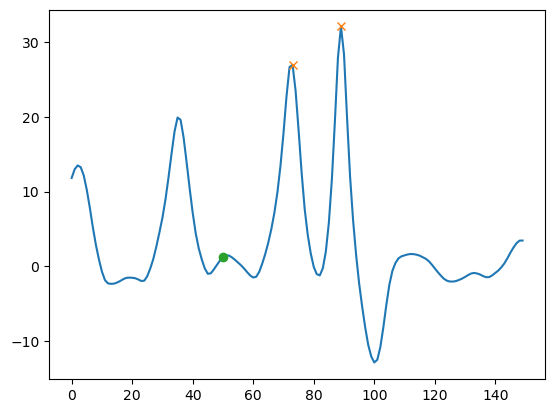

  2%|▏         | 8/417 [00:00<00:38, 10.65it/s]

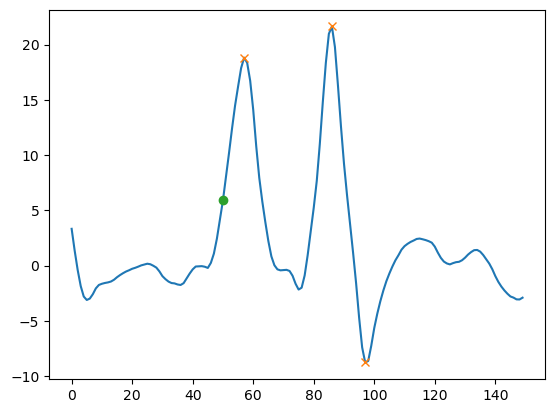

  2%|▏         | 10/417 [00:01<00:52,  7.73it/s]

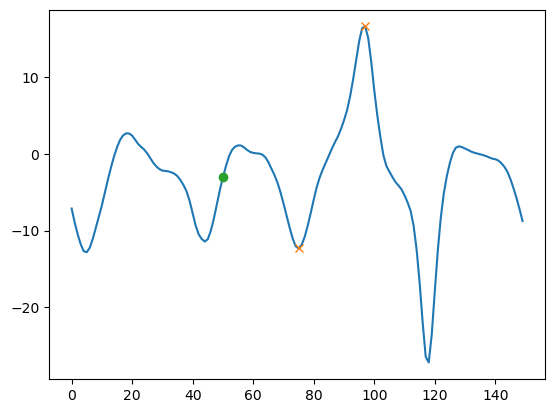

  3%|▎         | 12/417 [00:01<00:57,  7.08it/s]

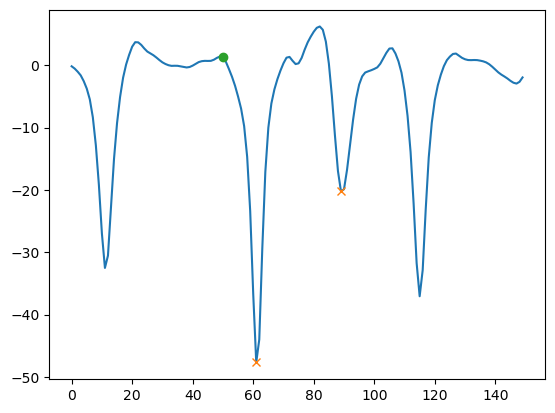

  5%|▍         | 19/417 [00:02<00:36, 11.01it/s]

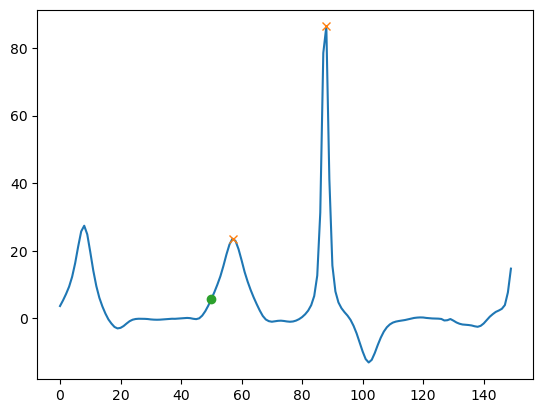

  6%|▌         | 25/417 [00:02<00:33, 11.62it/s]

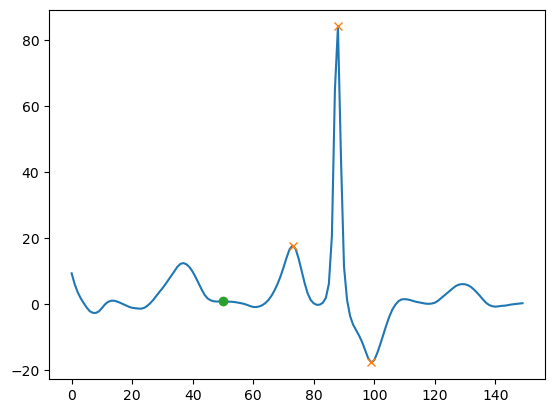

  7%|▋         | 31/417 [00:03<00:34, 11.09it/s]

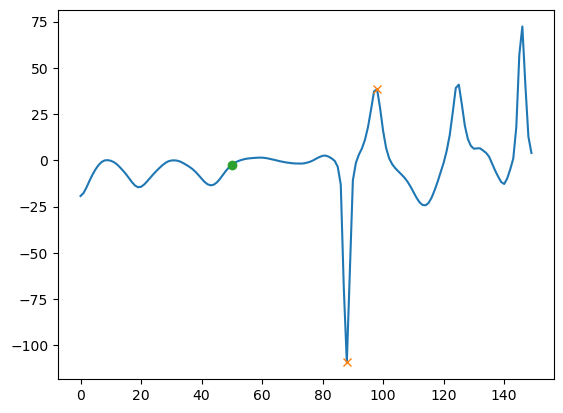

  8%|▊         | 33/417 [00:03<00:45,  8.49it/s]

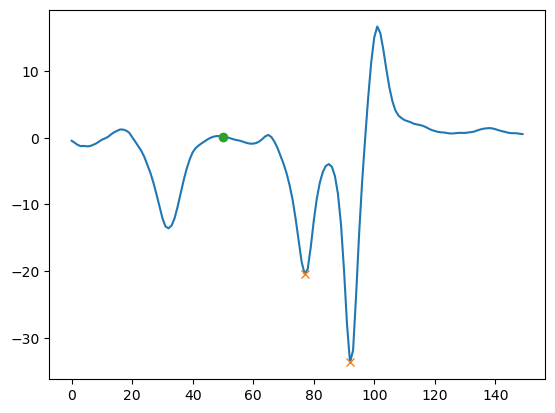

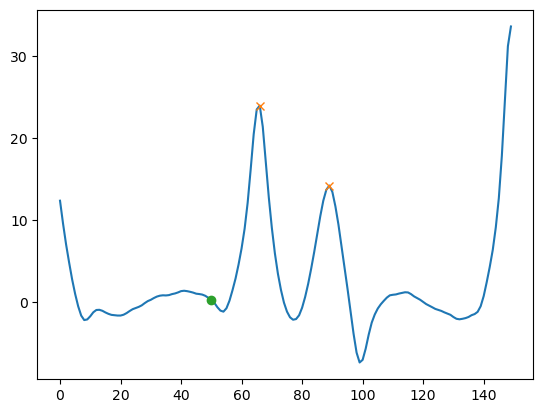

  8%|▊         | 35/417 [00:04<01:03,  6.00it/s]

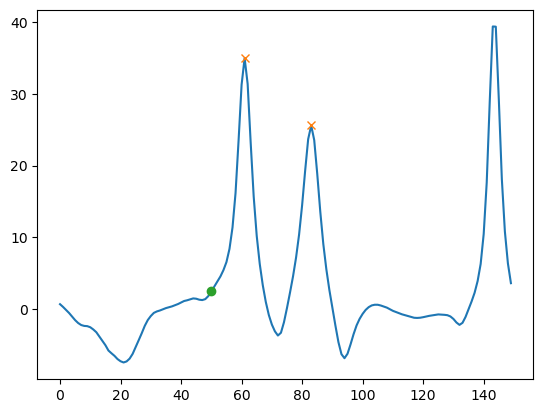

 11%|█         | 44/417 [00:04<00:32, 11.52it/s]

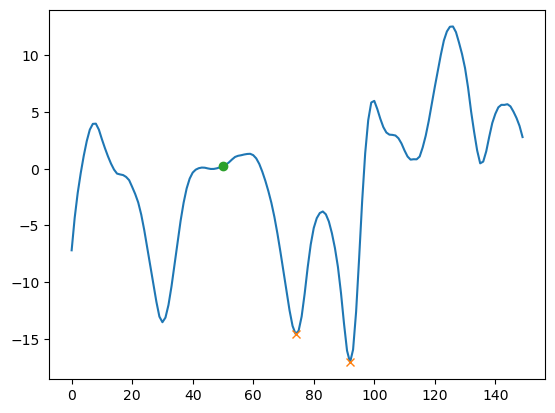

 12%|█▏        | 48/417 [00:05<00:36, 10.25it/s]

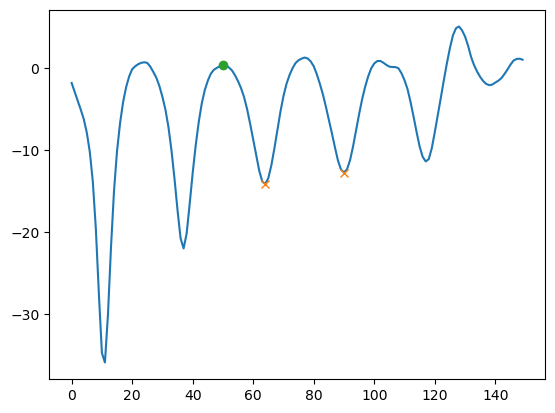

 12%|█▏        | 50/417 [00:05<00:44,  8.31it/s]

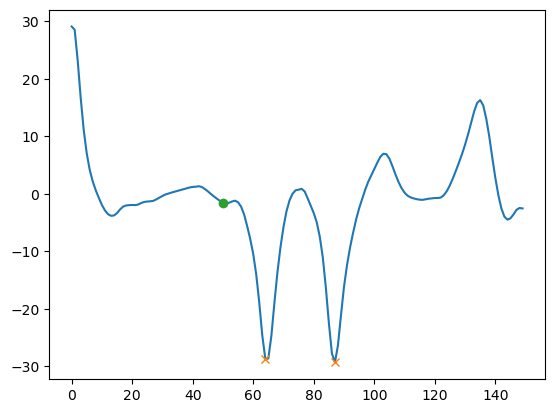

 15%|█▍        | 62/417 [00:06<00:26, 13.22it/s]

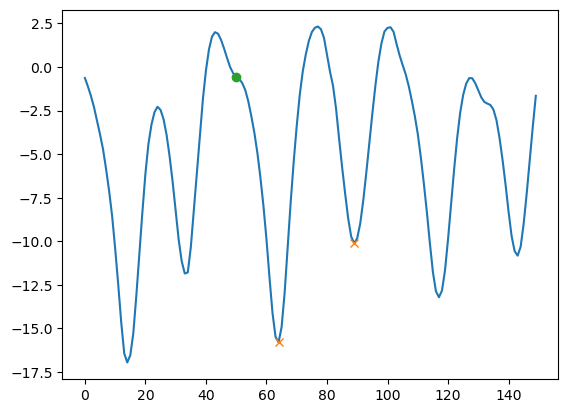

 16%|█▌        | 66/417 [00:07<00:34, 10.13it/s]

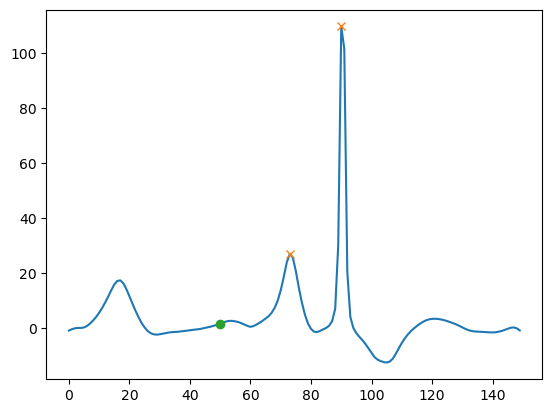

 16%|█▋        | 68/417 [00:07<00:42,  8.24it/s]

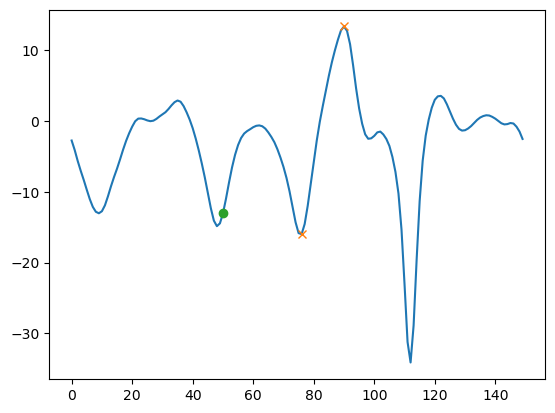

 17%|█▋        | 70/417 [00:08<00:47,  7.38it/s]

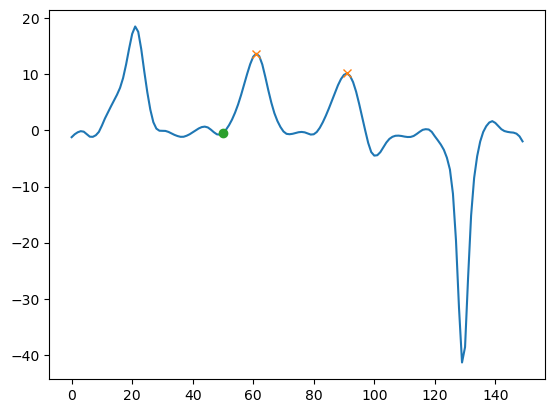

 17%|█▋        | 71/417 [00:08<00:56,  6.08it/s]

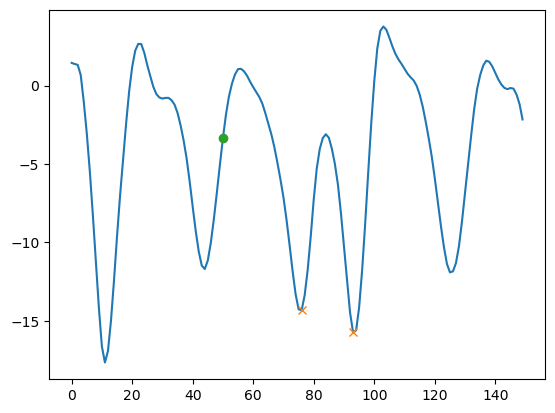

 18%|█▊        | 74/417 [00:08<00:48,  7.14it/s]

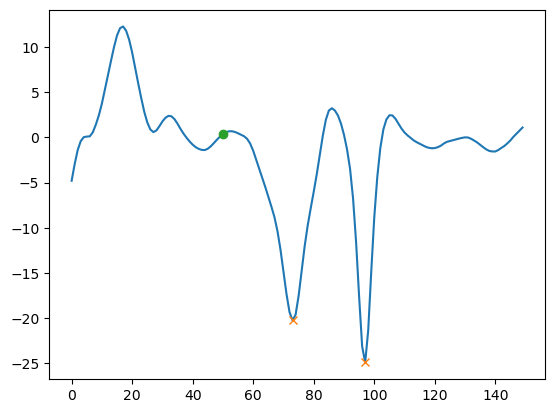

 18%|█▊        | 77/417 [00:09<00:45,  7.54it/s]

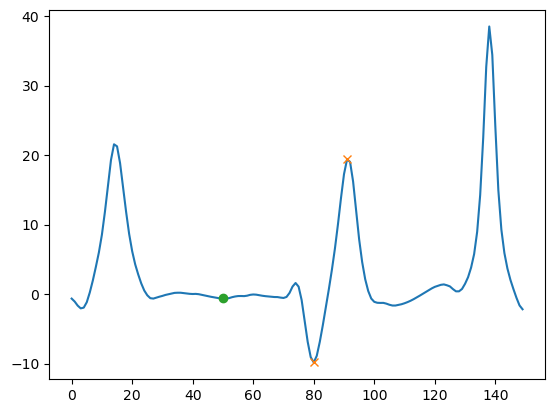

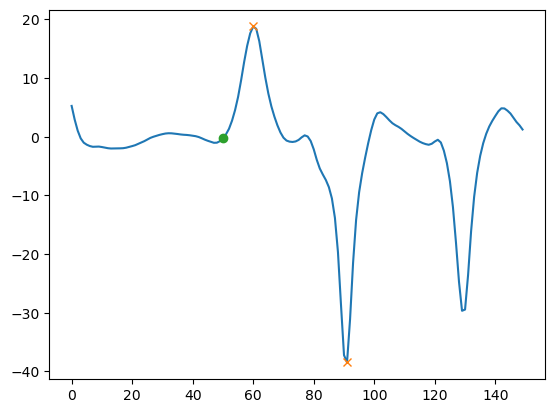

 19%|█▉        | 79/417 [00:09<01:04,  5.23it/s]

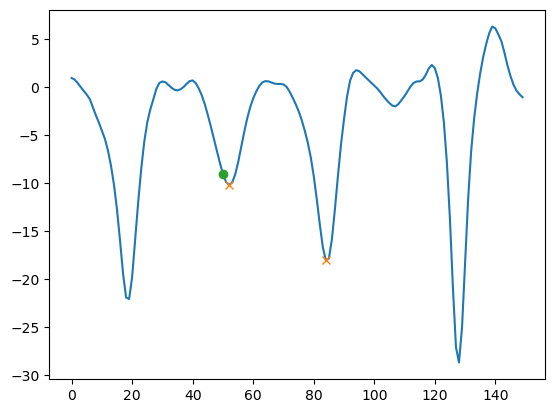

 19%|█▉        | 81/417 [00:10<01:03,  5.31it/s]

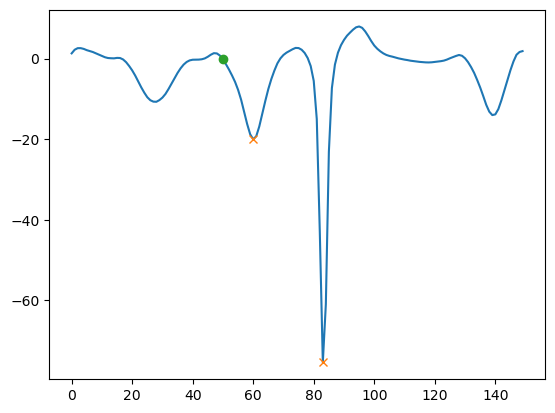

 20%|█▉        | 83/417 [00:10<01:00,  5.50it/s]

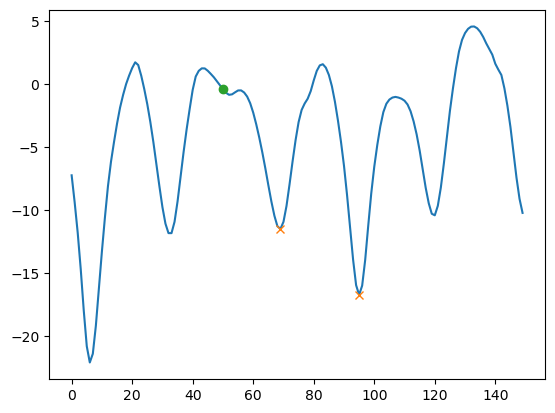

 20%|██        | 85/417 [00:10<00:59,  5.56it/s]

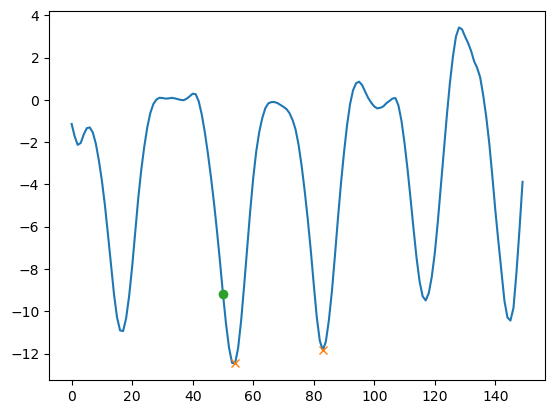

 21%|██        | 86/417 [00:11<01:08,  4.85it/s]

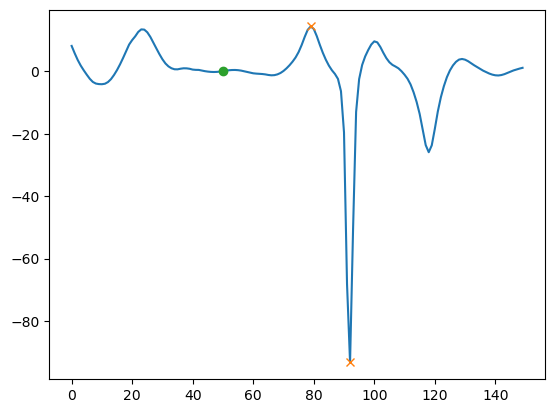

 21%|██        | 88/417 [00:11<01:05,  5.04it/s]

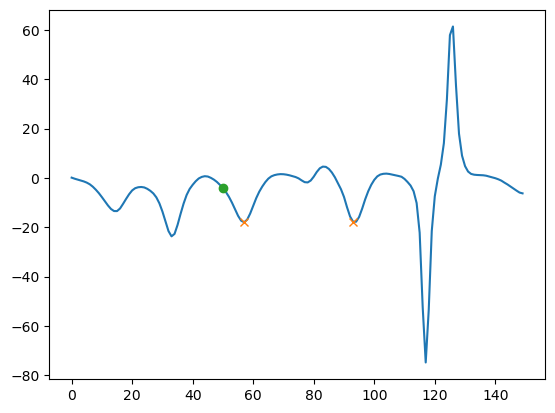

 22%|██▏       | 93/417 [00:12<00:41,  7.78it/s]

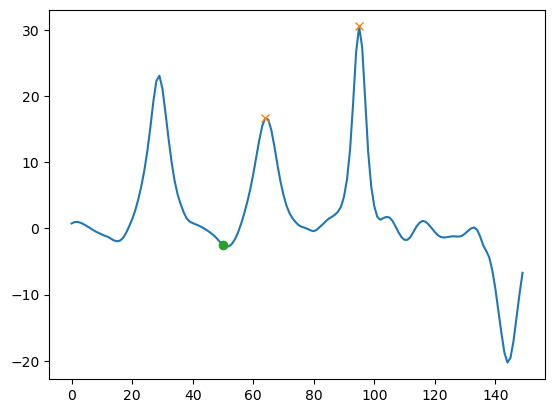

 24%|██▎       | 99/417 [00:12<00:31, 10.05it/s]

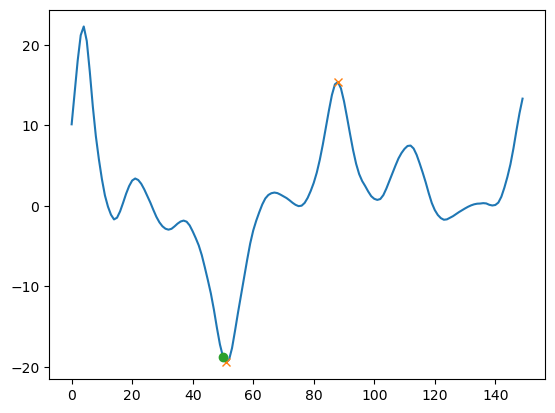

 25%|██▍       | 103/417 [00:13<00:31,  9.82it/s]

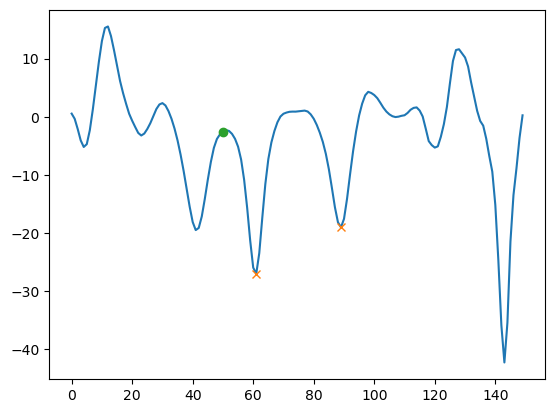

 25%|██▌       | 105/417 [00:13<00:39,  7.99it/s]

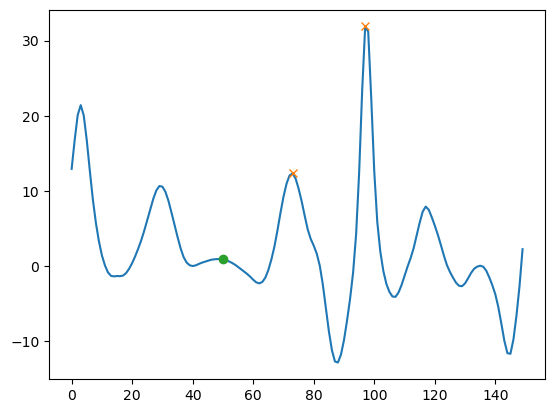

 26%|██▌       | 107/417 [00:13<00:43,  7.15it/s]

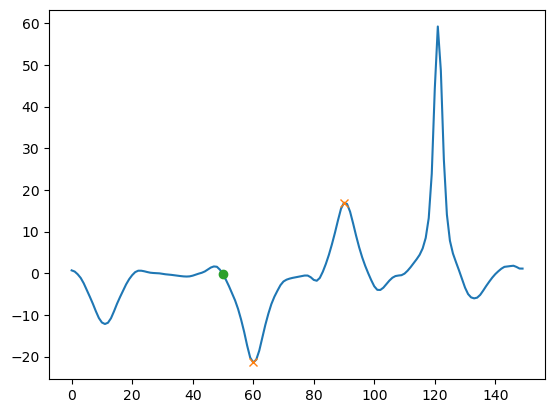

 27%|██▋       | 113/417 [00:14<00:31,  9.55it/s]

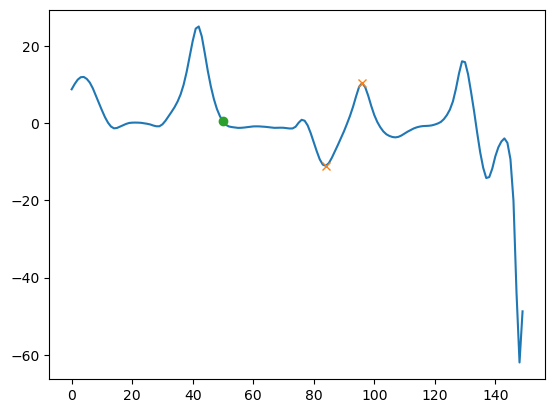

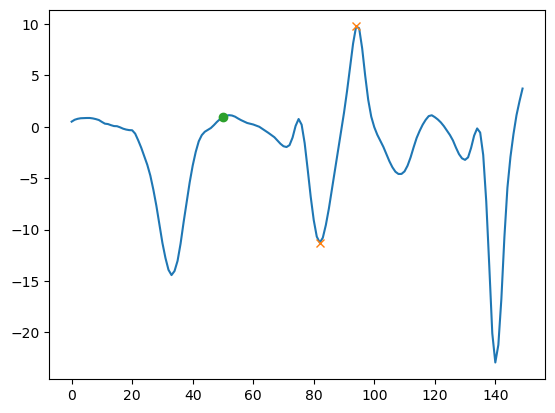

 29%|██▉       | 121/417 [00:15<00:28, 10.56it/s]

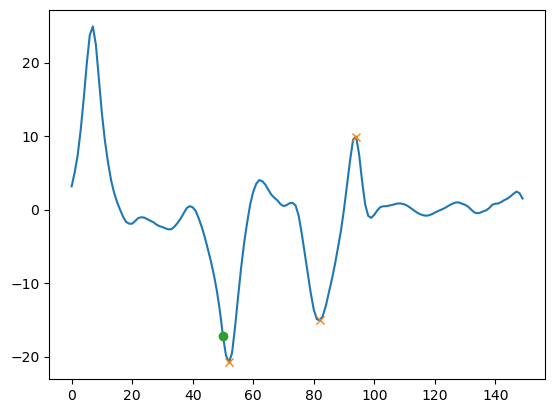

 30%|██▉       | 125/417 [00:15<00:29,  9.88it/s]

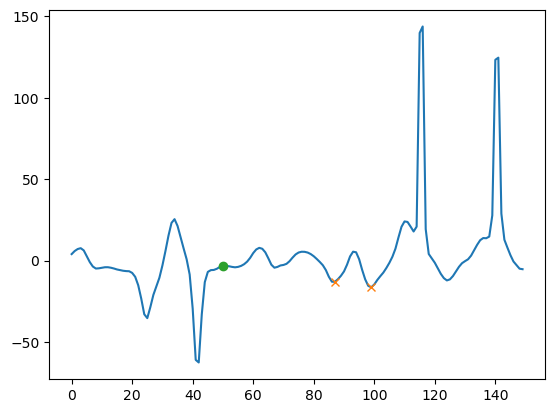

 31%|███▏      | 131/417 [00:16<00:25, 11.19it/s]

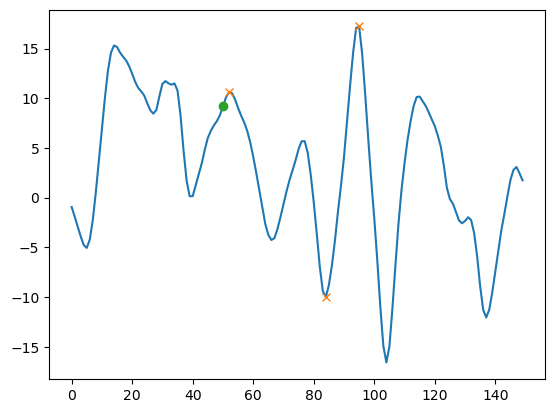

 32%|███▏      | 133/417 [00:16<00:33,  8.48it/s]

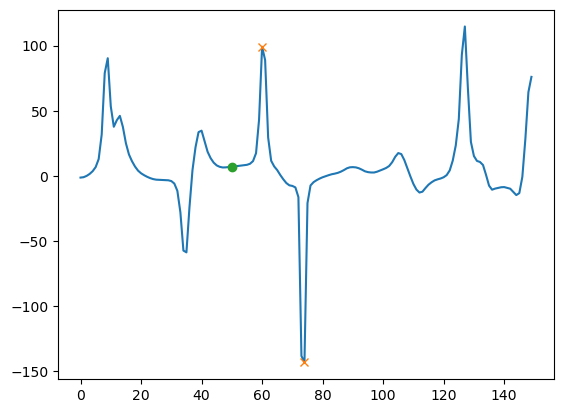

 33%|███▎      | 137/417 [00:17<00:31,  8.84it/s]

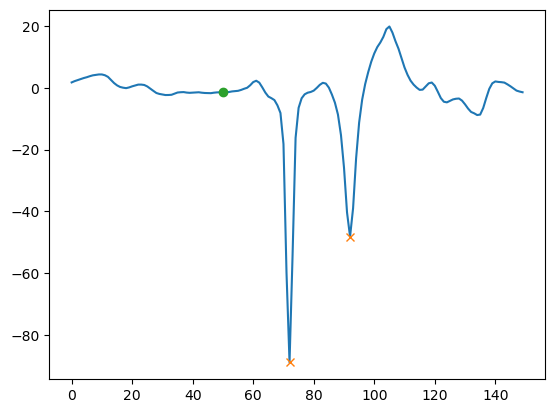

 36%|███▌      | 151/417 [00:18<00:17, 14.89it/s]

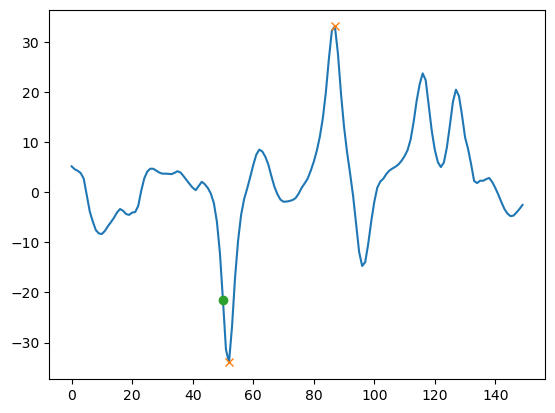

 37%|███▋      | 155/417 [00:18<00:22, 11.49it/s]

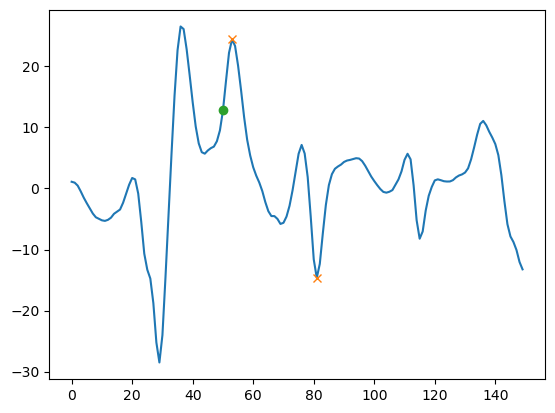

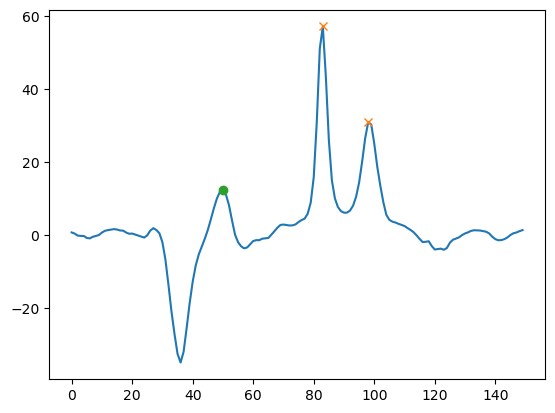

 38%|███▊      | 157/417 [00:19<00:37,  6.86it/s]

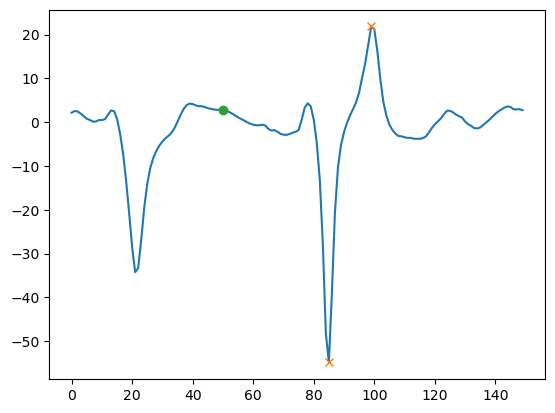

 39%|███▊      | 161/417 [00:19<00:33,  7.73it/s]

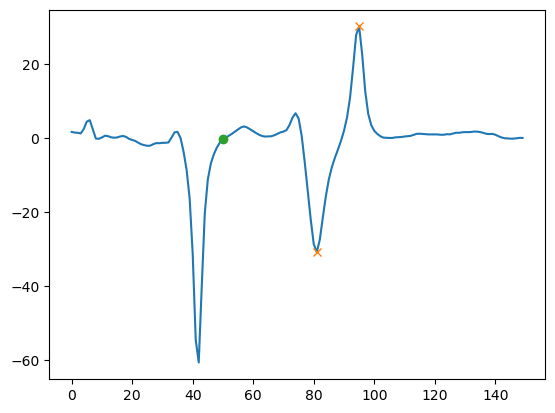

 40%|███▉      | 165/417 [00:20<00:29,  8.58it/s]

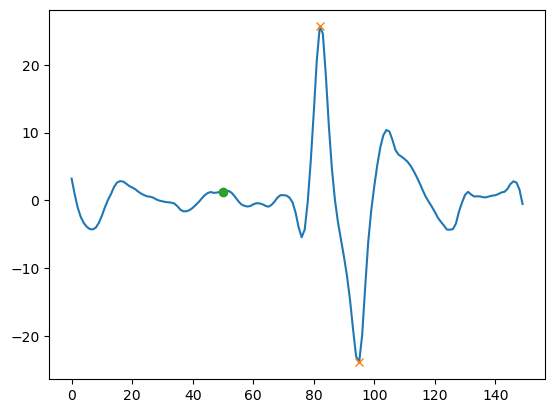

 40%|████      | 167/417 [00:20<00:33,  7.55it/s]

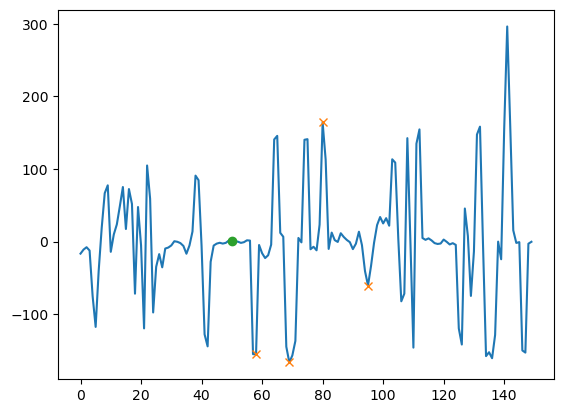

 41%|████      | 171/417 [00:21<00:29,  8.36it/s]

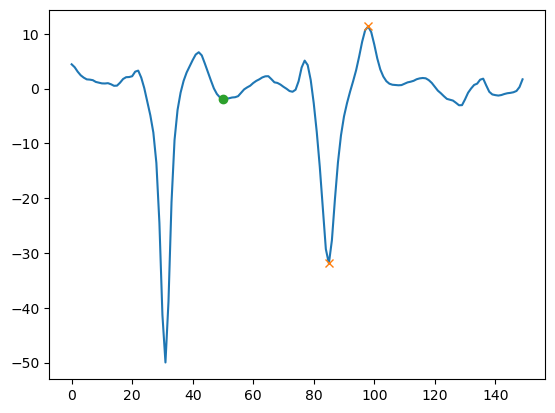

 41%|████▏     | 173/417 [00:21<00:34,  7.14it/s]

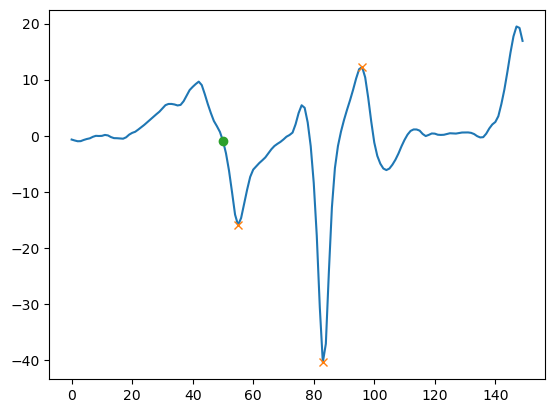

 42%|████▏     | 174/417 [00:21<00:42,  5.67it/s]

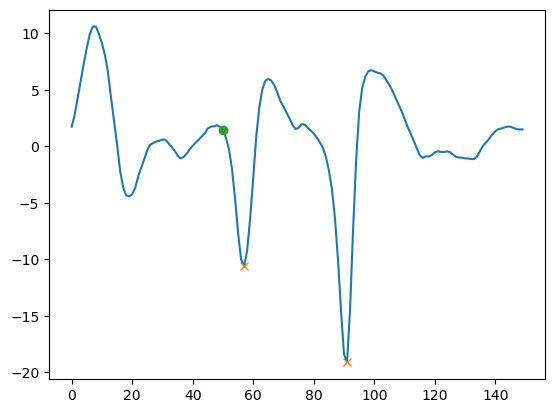

 43%|████▎     | 181/417 [00:22<00:23, 10.09it/s]

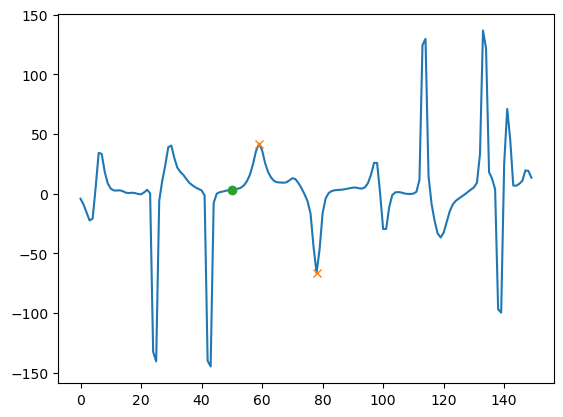

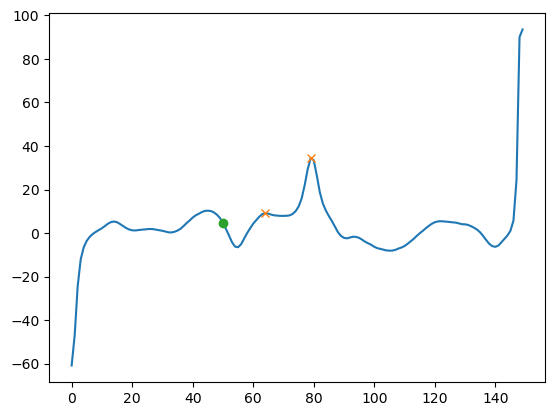

 44%|████▍     | 183/417 [00:23<00:38,  6.11it/s]

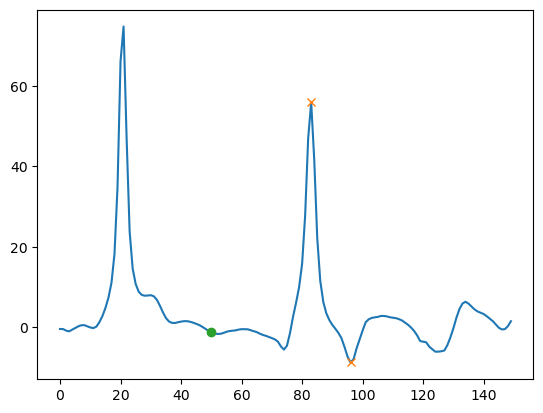

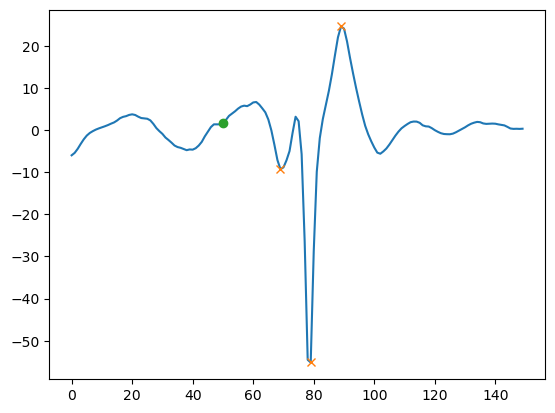

 47%|████▋     | 195/417 [00:24<00:19, 11.54it/s]

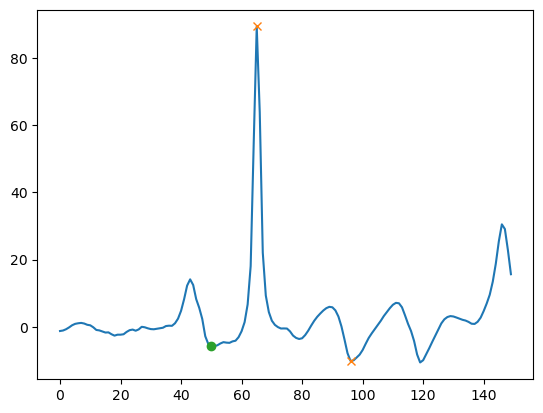

 47%|████▋     | 197/417 [00:24<00:24,  8.99it/s]

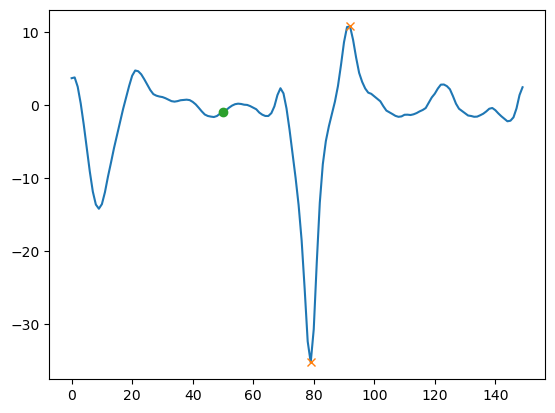

 48%|████▊     | 199/417 [00:25<00:27,  7.81it/s]

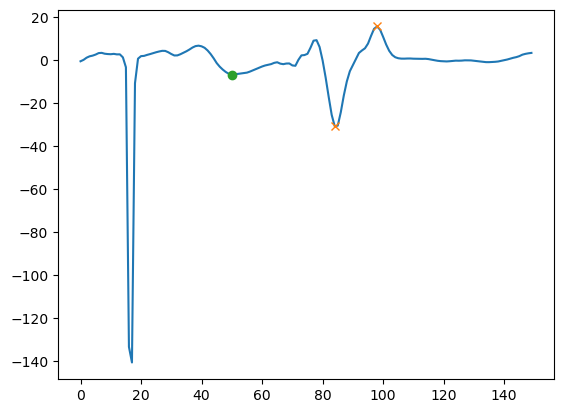

 48%|████▊     | 201/417 [00:25<00:31,  6.80it/s]

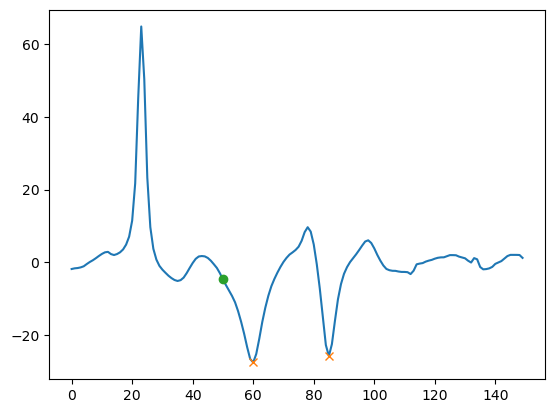

 49%|████▊     | 203/417 [00:25<00:33,  6.43it/s]

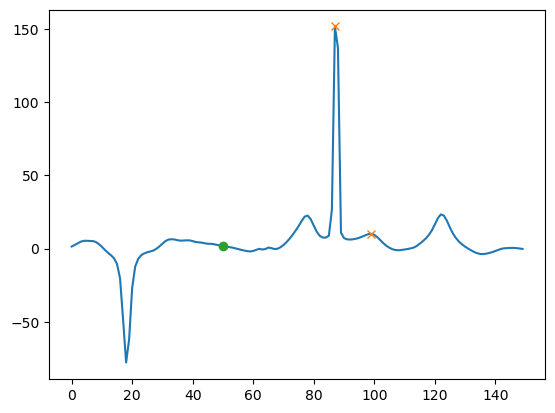

 49%|████▉     | 204/417 [00:26<00:39,  5.41it/s]

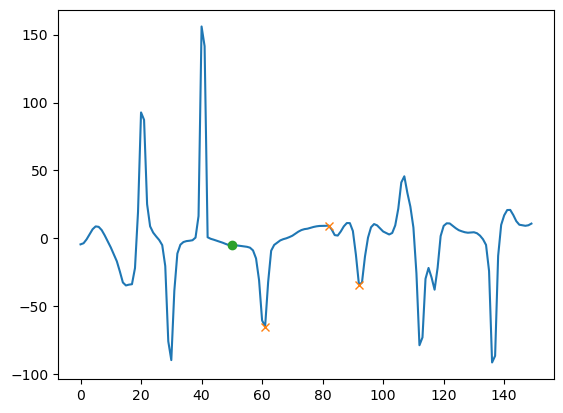

 49%|████▉     | 205/417 [00:26<00:45,  4.68it/s]

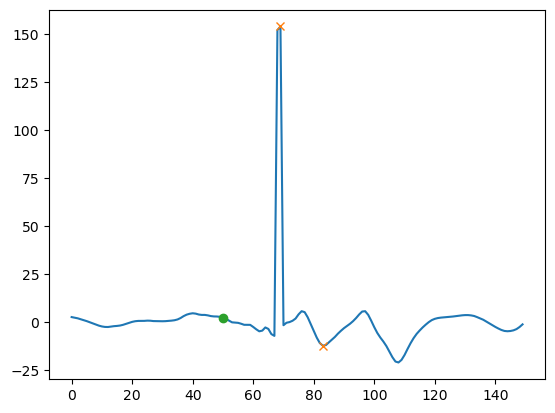

 53%|█████▎    | 222/417 [00:27<00:13, 14.83it/s]

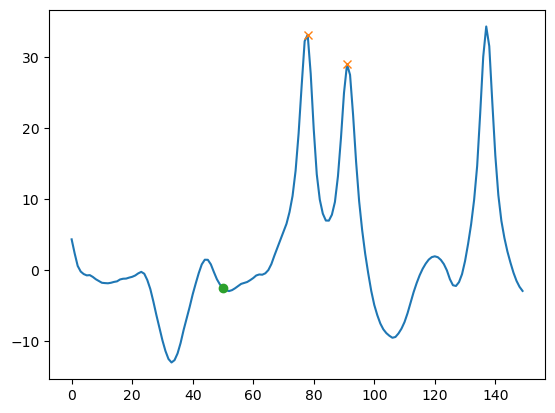

 55%|█████▌    | 230/417 [00:28<00:13, 13.69it/s]

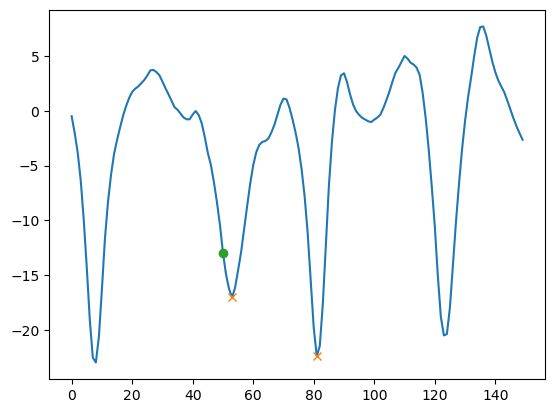

 58%|█████▊    | 242/417 [00:29<00:11, 14.65it/s]

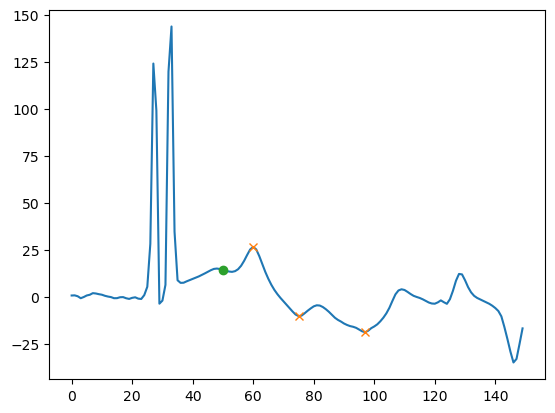

 59%|█████▉    | 246/417 [00:29<00:15, 11.06it/s]

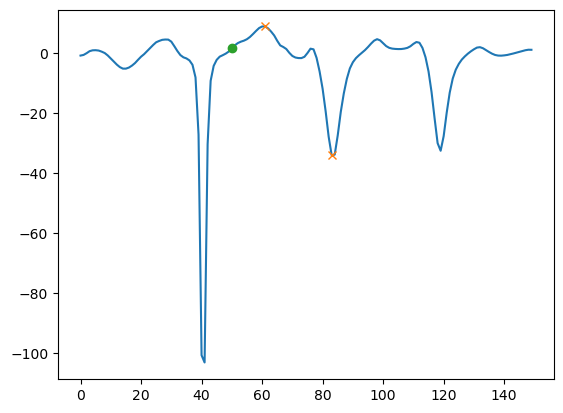

 59%|█████▉    | 248/417 [00:30<00:19,  8.77it/s]

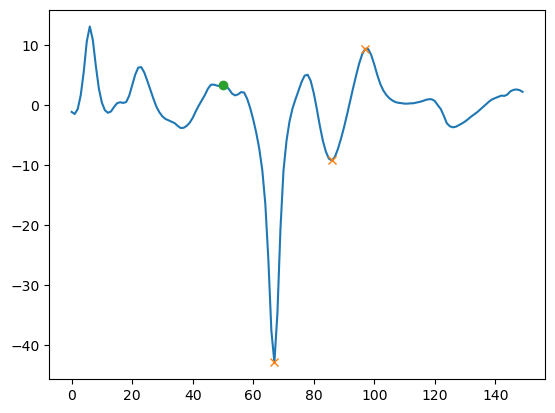

 61%|██████    | 254/417 [00:30<00:19,  8.21it/s]


KeyboardInterrupt: 

In [104]:
results_df = process_movement_data(stim, df)

KeyError: 'angular_velocity'

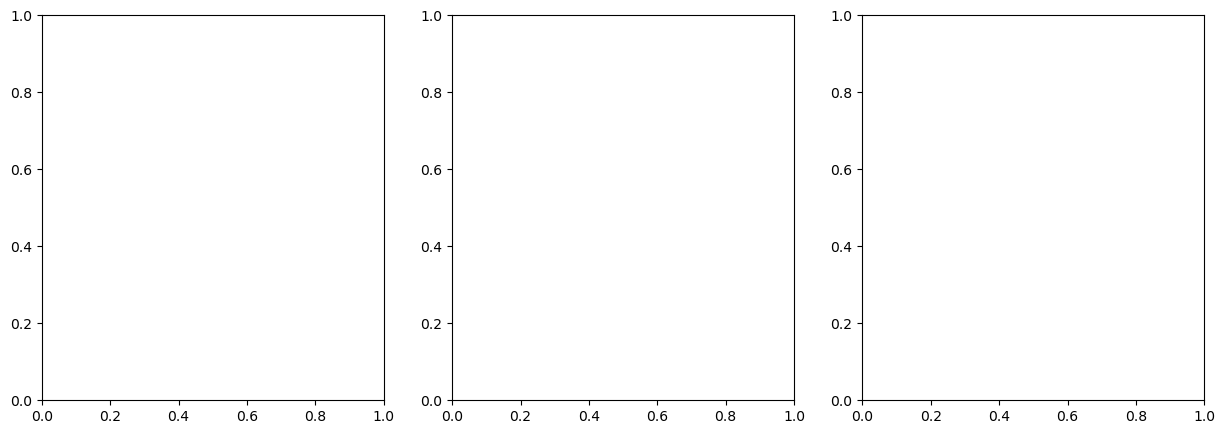

In [91]:
plot_results(results_df)

### GMM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway, ks_2samp, norm
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multicomp import pairwise_tukeyhsd


def analyze_gmm(data, label, n_components=3):
    X = np.array(data).reshape(-1, 1)

    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)

    x = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)

    # Set up the plot style
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6), dpi=90)

    # Plot histogram
    sns.histplot(data=X, stat="density", kde=False, color="lightgray", alpha=0.7, ax=ax)

    # Plot overall GMM
    ax.plot(x, np.exp(logprob), color="black", lw=2, label="GMM")

    # Plot individual components
    colors = ["#FF9999", "#66B2FF", "#99FF99"]
    for i in range(n_components):
        pdf = (
            responsibilities[:, i]
            * gmm.weights_[i]
            * norm.pdf(x, gmm.means_[i], np.sqrt(gmm.covariances_[i]))
        )
        ax.plot(x, pdf, color=colors[i], lw=2, ls="--", label=f"Component {i+1}")

    ax.set_xlabel("Heading Change (degrees)", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(
        f"Gaussian Mixture Model of Turn Bias - {label}", fontsize=14, fontweight="bold"
    )
    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 0.015)
    ax.legend(fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=10)

    plt.tight_layout()
    plt.savefig(
        f'notebooks/Figures/gmm_analysis_{label.replace(" ", "_")}.png',
        dpi=90,
        bbox_inches="tight",
    )
    plt.show()

    # Print the parameters of each component
    print(f"\nResults for {label}:")
    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        print(f"Component {i+1}:")
        print(f"  Mean: {mean[0]:.2f}")
        print(f"  Standard Deviation: {np.sqrt(cov[0][0]):.2f}")
        print(f"  Weight: {gmm.weights_[i]:.2f}")

    return gmm


def perform_statistical_tests(heading_change_df):
    groups = heading_change_df["group"].unique()

    # Kolmogorov-Smirnov test
    print("\nKolmogorov-Smirnov Test Results:")
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = heading_change_df[heading_change_df["group"] == groups[i]][
                "heading_change"
            ]
            group2 = heading_change_df[heading_change_df["group"] == groups[j]][
                "heading_change"
            ]
            ks_statistic, p_value = ks_2samp(group1, group2)
            print(
                f"{groups[i]} vs {groups[j]}: statistic = {ks_statistic:.4f}, p-value = {p_value:.4f}"
            )

    # One-way ANOVA
    f_statistic, p_value = f_oneway(
        *[
            heading_change_df[heading_change_df["group"] == group]["heading_change"]
            for group in groups
        ]
    )
    print("\nOne-way ANOVA Results:")
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Tukey's HSD post-hoc test
    tukey_results = pairwise_tukeyhsd(
        heading_change_df["heading_change"], heading_change_df["group"]
    )
    print("\nTukey's HSD Test Results:")
    print(tukey_results)


# Analyze each group separately
gmm_results = {}
for group in heading_change_df["group"].unique():
    group_data = heading_change_df[heading_change_df["group"] == group][
        "heading_change"
    ].values
    gmm_results[group] = analyze_gmm(group_data, group)

# Perform statistical tests
perform_statistical_tests(heading_change_df)

# Optional: Analyze all data combined
all_data = heading_change_df["heading_change"].values
analyze_gmm(all_data, "All Groups Combined")

# Statistics

In [ ]:
# calculate max angular velocity in stim window for each group
j53_max_angvel = np.max(j53_data["angular_velocity"], axis=1)
g29_max_angvel = np.max(g29_data["angular_velocity"], axis=1)
empty_max_angvel = np.max(empty_data["angular_velocity"], axis=1)


# organize data in long dataframe
angvel_df = pd.DataFrame(
    {
        "group": ["Empty-split"] * len(empty_max_angvel)
        + ["DNp03"] * len(j53_max_angvel)
        + ["AX"] * len(g29_max_angvel),
        "max": np.concatenate([empty_max_angvel, j53_max_angvel, g29_max_angvel]),
    }
)

# print summary statistics
print(angvel_df.groupby("group").describe())

In [ ]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


def analyze_data(df, group1, group2):
    output = StringIO()

    def print_section(title):
        print(f"\n{title}\n{'-' * len(title)}", file=output)

    data1 = df[df["group"] == group1]["max"]
    data2 = df[df["group"] == group2]["max"]

    print_section("Data Summary")
    for name, data in [(group1, data1), (group2, data2)]:
        print(f"{name}:", file=output)
        print(f"  Sample size: {len(data)}", file=output)
        print(f"  Mean: {np.mean(data):.4f}", file=output)
        print(f"  Median: {np.median(data):.4f}", file=output)
        print(f"  Standard deviation: {np.std(data, ddof=1):.4f}", file=output)

    print_section("Normality Test (Shapiro-Wilk)")
    for name, data in [(group1, data1), (group2, data2)]:
        statistic, p_value = stats.shapiro(data)
        print(f"{name}:", file=output)
        print(f"  Statistic: {statistic:.4f}", file=output)
        print(f"  p-value: {p_value:.4f}", file=output)
        print(f"  Normal: {'Yes' if p_value > 0.05 else 'No'}", file=output)

    print_section("Equality of Variances (Levene's Test)")
    statistic, p_value = stats.levene(data1, data2)
    print(f"Statistic: {statistic:.4f}", file=output)
    print(f"p-value: {p_value:.4f}", file=output)
    print(f"Equal variances: {'Yes' if p_value > 0.05 else 'No'}", file=output)

    print_section("Distribution Shape Comparison")
    ks_statistic, p_value = stats.ks_2samp(data1, data2)
    print(f"Kolmogorov-Smirnov test:", file=output)
    print(f"  Statistic: {ks_statistic:.4f}", file=output)
    print(f"  p-value: {p_value:.4f}", file=output)
    print(f"  Similar shape: {'Yes' if p_value > 0.05 else 'No'}", file=output)

    print_section("Presence of Ties")
    ties1 = len(data1) - len(data1.unique())
    ties2 = len(data2) - len(data2.unique())
    print(f"{group1} ties: {ties1}", file=output)
    print(f"{group2} ties: {ties2}", file=output)
    print(
        f"Significant ties: {'Yes' if (ties1 + ties2) / (len(data1) + len(data2)) > 0.1 else 'No'}",
        file=output,
    )

    print_section("Outlier Detection (IQR method)")
    for name, data in [(group1, data1), (group2, data2)]:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        print(f"{name} outliers: {outliers}", file=output)

    print_section("Effect Size (Cohen's d)")
    d = (data1.mean() - data2.mean()) / np.sqrt(
        (data1.std(ddof=1) ** 2 + data2.std(ddof=1) ** 2) / 2
    )
    print(f"Cohen's d: {d:.4f}", file=output)
    if abs(d) < 0.2:
        print("Effect size: Small", file=output)
    elif abs(d) < 0.5:
        print("Effect size: Medium", file=output)
    else:
        print("Effect size: Large", file=output)

    # Generate histograms
    plt.figure(figsize=(10, 6))
    plt.hist(data1, bins=20, alpha=0.5, label=group1)
    plt.hist(data2, bins=20, alpha=0.5, label=group2)
    plt.legend()
    plt.title("Histogram of Data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.savefig("histogram.png")
    plt.close()

    # Generate Q-Q plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    stats.probplot(data1, dist="norm", plot=ax1)
    ax1.set_title(f"Q-Q Plot: {group1}")
    stats.probplot(data2, dist="norm", plot=ax2)
    ax2.set_title(f"Q-Q Plot: {group2}")
    plt.tight_layout()
    plt.savefig("qq_plots.png")
    plt.close()

    return output.getvalue()


result = analyze_data(angvel_df, group1="Empty-split", group2="AX")
print(result)
print(
    "\nHistogram and Q-Q plots have been saved as 'histogram.png' and 'qq_plots.png'."
)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats


def perform_mann_whitney_u_test(df, group1, group2):
    # Split data into two groups

    data1 = df[df["group"] == group1]["max"]
    data2 = df[df["group"] == group2]["max"]

    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(data1, data2, alternative="two-sided")

    # Calculate effect size (r)
    n1, n2 = len(data1), len(data2)
    z = abs(statistic - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    effect_size = z / np.sqrt(n1 + n2)

    # Prepare output
    output = f"""
Mann-Whitney U Test Results
===========================

Groups: {group1} vs {group2}

Test Statistic: {statistic:.4f}
p-value: {p_value:.4f}

Effect Size (r): {effect_size:.4f}
Interpretation: {interpret_effect_size(effect_size)}

Sample Sizes:
  {group1}: {n1}
  {group2}: {n2}

Median Values:
  {group1}: {data1.median():.4f}
  {group2}: {data2.median():.4f}

Interpretation:
{interpret_results(p_value, effect_size)}
"""
    return output


def interpret_effect_size(r):
    if abs(r) < 0.1:
        return "Negligible effect"
    elif abs(r) < 0.3:
        return "Small effect"
    elif abs(r) < 0.5:
        return "Medium effect"
    else:
        return "Large effect"


def interpret_results(p_value, effect_size):
    if p_value < 0.05:
        significance = (
            "There is a statistically significant difference between the two groups"
        )
    else:
        significance = (
            "There is no statistically significant difference between the two groups"
        )

    effect = f"The effect size is {interpret_effect_size(effect_size).lower()}."

    caution = (
        "Note: Due to the different shapes of the distributions, "
        "interpret these results as a comparison of rank distributions "
        "rather than strictly as a comparison of medians."
    )

    return f"{significance} (p < 0.05). {effect}\n\n{caution}"


result = perform_mann_whitney_u_test(angvel_df, group1="Empty-split", group2="DNp03")
print(result)

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scikit_posthocs import posthoc_dunn
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# 1. Test for normality (Shapiro-Wilk test)
def test_normality(df, var):
    for group in df["group"].unique():
        _, p_value = stats.shapiro(df[df["group"] == group][var])
        print(f"Shapiro-Wilk test p-value for {group}: {p_value:.4f}")


# 2. Test for homogeneity of variances (Levene's test)
def test_homogeneity(df, var):
    groups = [group for _, group in df.groupby("group")[var]]
    _, p_value = stats.levene(*groups)
    print(f"Levene's test p-value: {p_value:.4f}")


# 3. Visualize distributions
def plot_distributions(df, var):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="group", y=var, data=df)
    plt.title(f"Distribution of {var} by Group")
    plt.show()


# 4. Perform one-way ANOVA
def perform_anova(df, var):
    model = ols(f"{var} ~ C(group)", data=df).fit()
    anova_table = anova_lm(model, typ=2)
    print(anova_table)


# 5. Perform Kruskal-Wallis H-test (non-parametric alternative)
def perform_kruskal(df, var):
    groups = [group for _, group in df.groupby("group")[var]]
    h_statistic, p_value = stats.kruskal(*groups)
    degrees_of_freedom = len(groups) - 1  # degrees of freedom for Kruskal-Wallis
    print(f"Kruskal-Wallis H-test results:")
    print(f"H-statistic: {h_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {degrees_of_freedom}")
    return h_statistic, p_value, degrees_of_freedom


# 6. Post-hoc test (Tukey's HSD)
def perform_tukey(df, var):
    tukey = pairwise_tukeyhsd(endog=df[var], groups=df["group"], alpha=0.05)
    print(tukey)


def perform_dunns(df, var):
    dunn = posthoc_dunn(df, val_col=var, group_col="group", p_adjust="bonferroni")
    print("Dunn's test results:")
    print(dunn)

    # Extract pairwise comparisons
    groups = df["group"].unique()
    pairwise_results = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1, group2 = groups[i], groups[j]
            p_value = dunn.loc[group1, group2]
            pairwise_results.append((group1, group2, p_value))

    return pairwise_results


# Function to run all tests and visualizations
def run_analysis(df, var):
    print(f"Analysis for variable: {var}")
    print("-" * 40)
    test_normality(df, var)
    test_homogeneity(df, var)
    plot_distributions(df, var)
    h_statistic, kw_p_value, degrees_of_freedom = perform_kruskal(df, var)
    dunn_results = perform_dunns(df, var)
    return h_statistic, kw_p_value, degrees_of_freedom, dunn_results


## Organize data

## Test for assumptions

In [ ]:
run_analysis(angvel_df, "max")